This notebook has a collection of helper functions for exploring a benchmarking result against SMaHT MIMS.

The recommended truvari parameters and conversion of the truvari result into a dataframe is:

```bash
truvari bench -p 0.9 -P 0.9 --passonly --pick multi \
    --includebed $bed -b $base -c $comp \
    -o ${name}_result/
truvari vcf2df -i -f -b ${name}_result/ ${name}_result/data.jl
```

The resultant `data.jl` can be input here.

In [1]:
import joblib
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import truvari
from scipy.stats import pearsonr

In [46]:
def size_type_metrics(df):
    """
    Makes a dataframe of precision/recall/f1 by sv type and size
    """
    rows = []
    for i, sub in df.groupby(['szbin', 'svtype'], observed=False):
        cnts = sub['state'].value_counts()
        rows.append((*i, * truvari.performance_metrics(**cnts)))
    ret = pd.DataFrame(rows, columns=['szbin', 'svtype', 'precision', 'recall', 'f1'])
    return ret.dropna()

def size_type_barplot(metrics, y="recall", title="Size/Type Performance"):
    """
    Simple barplot of y=recall/precision/f1 by svsize hue svtype
    metrics = output from `size_type_metrics`
    Returns a seaborn plot
    """
    p = sb.barplot(data=metrics, x='szbin', y=y, hue='svtype')
    p.set(title=title, xlabel="SizeBin")
    _ = plt.xticks(rotation=45, ha='right')
    return p

def split_base_comp(data):
    """
    Separates dataframe rows into those from the baseline and from the comparison VCF.
    Extracts Truvari's MatchId annotation so the subsets have a key to potentially joine one another
    """
    # Separate out the variants from the base VCF and add new columns of the base/comp ids
    base = data[data['state'].isin(['tpbase', 'fn'])].copy()
    base['base_id'] = base['MatchId'].apply(lambda x: x[0])
    base['comp_id'] = base['MatchId'].apply(lambda x: x[1])

    # Separate out the variants from the comparison VCF and add new columns of the base/comp ids
    comp = data[data['state'].isin(['tp', 'fp'])].copy()
    comp['base_id'] = comp['MatchId'].apply(lambda x: x[0])
    comp['comp_id'] = comp['MatchId'].apply(lambda x: x[1])
    base.reset_index(inplace=True)
    comp.reset_index(inplace=True)
    return base, comp

def sniffles_vaf(df, sample):
    """
    Calculate sniffles' predicted vaf
    """
    dv = df[f'{sample}_DV']
    dr = df[f'{sample}_DR']
    tot = dv + dr
    return dv / tot

def sawfish_vaf(df, sample):
    """
    Calculate sawfish' predicted vaf
    """
    dr = df[f'{sample}_AD_ref']
    dv = df[f'{sample}_AD_alt']
    tot = dr + dv
    return dv / (dv+dr)

def svdss_vaf(df, sample):
    """
    Calculate sawfish' predicted vaf
    """
    return df['WEIGHT'] / df['COV']

tool_vaf = {'sniffles': sniffles_vaf,
            'svdss': svdss_vaf,
            'sawfish': sawfish_vaf}

def get_predicted_vaf(comp, sample="", tool=None):
    """
    Calculate the predicted_vaf annotation for a dataframe 
    Supported tools: svdss, sniffles, sawfish
    """
    if tool not in tool_vaf.keys():
        raise Exception(f"Unexpected tool name {tool}")
    return tool_vaf[tool](comp, sample)

def get_vaf_bin(vaf, bins=[0, 0.05, 0.3, 0.7, 1], labels=["Ultra-Low", "Low", "Medium", "High"]):
    """
    Bin VAFs and apply labels
    """
    return pd.cut(vaf, bins=bins, labels=labels) 

def fill_in_vafs(base, comp):
    """
    Sets predicted and expected vaf columns for base and comp dataframes
    """
    sum_vaf = base[base['state'] == 'tpbase'].groupby(['comp_id'])['expected_vaf'].sum()
    a = comp[(comp['state'] == 'tp') & ~comp['comp_id'].isin(sum_vaf.index)][['base_id', 'comp_id']].copy()
    b = base[base['base_id'].isin(a['base_id'])]
    a.set_index('base_id', inplace=True)
    b.set_index('base_id', inplace=True)
    a['expected_vaf'] = b['expected_vaf']
    a = a.reset_index(drop=True).set_index('comp_id')
    sum_vaf = pd.concat([sum_vaf, a])

    comp.set_index('comp_id', inplace=True)
    comp['expected_vaf'] = sum_vaf.where(sum_vaf <= 1, 1)
    comp.reset_index(inplace=True)

    sum_vaf = comp[comp['state'] == 'tp'].groupby(['base_id'])['predicted_vaf'].sum()
    a = base[(base['state'] == 'tpbase') & ~base['base_id'].isin(sum_vaf.index)][['base_id', 'comp_id']].copy()
    b = comp[comp['comp_id'].isin(a['comp_id'])]
    a.set_index('comp_id', inplace=True)
    b.set_index('comp_id', inplace=True)

    a['predicted_vaf'] = b['predicted_vaf']
    a = a.reset_index(drop=True).set_index('base_id')
    sum_vaf = pd.concat([sum_vaf, a])

    base.set_index('base_id', inplace=True)
    base['predicted_vaf'] = sum_vaf.where(sum_vaf <= 1, 1)
    base.reset_index(inplace=True)

def vaf_performance(predicted, expected):
    """
    Summarize the difference of predicted and expected vaf
    Returns a DataFrame with the description of the predicted-expected distribution
    As well as PearsonR coefficient and Pval, and mean-square error (MSE)
    """
    o1 = (predicted - expected).describe().to_frame()
    o2 = pearsonr(predicted, expected)
    o1.loc["PearsonR"] = o2.statistic
    o1.loc["Pval"] = o2.pvalue

    MSE = ((predicted - expected) ** 2).sum()  / len(predicted)
    o1.loc['MSE'] = MSE
    return o1

def comp_add_base_anno(comp, base):
    """
    Add the NumNeighbors and TRF annotations from base to the comp dataframe
    Edits them in place
    """
    comp.set_index('base_id', inplace=True)
    base.set_index('base_id', inplace=True)

    comp['NumNeighbors'] = base['NumNeighbors']
    comp['TRF'] = base['TRF']
    comp.reset_index(inplace=True)
    base.reset_index(inplace=True)

    
def make_mosaic_df(base, comp):
    """
    Given a truvari vcf2df dataframe
    Unite the predicted/expected vaf and baseline specific annotations 
    Returns a new, cleaned up datafraome
    """
    base['expected_vaf'] = base['VAF_alt']

    fill_in_vafs(base, comp)
    comp_add_base_anno(comp, base)

    columns = ['svtype', 'svlen', 'szbin', 'TRF', 'NumNeighbors', 'expected_vaf', 'predicted_vaf', 'state', 'hash']

    base = base[columns]
    comp = comp[columns]

    data = pd.concat([base, comp])

    data['expected_vaf_bin'] = get_vaf_bin(data['expected_vaf'])
    data['predicted_vaf_bin'] = get_vaf_bin(data['predicted_vaf'])
    data['matching_vaf_bin'] = data['expected_vaf_bin'] == data['predicted_vaf_bin']
    data['vaf-delta'] = data['predicted_vaf'] - data['expected_vaf']
    return data

# Preparing the data - Expected SUM VAF

It's possible that a variant caller will make a single 'consensus' call that is the representation of multiple highly similar baseline variants. For example, the benchmark may have a 100bp and 102bp deletion. A caller may not be able to distinguish the 2bp difference from sequencing error and will report a single 101bp deletion. By performing benchmarking with `truvari bench --pick multi`, we've allowed the two baseline deletions to match to the single comparison deletion. Therefore, we must alter the baseline's expected VAF to be the sum of the two deletions. This will allow the caller's 'consensus' variant's predicted VAF to more accurately reflect the expected VAF.

To setup the VAFs and create a streamlined DataFrame with results, we will follow these steps:

1. Load our truvari result
2. Separate the baseline and comparison variants
3. Calculate the comparison variants' predicted VAF
4. Create the mosaic benchmark DataFrame

In [32]:
tru_data = joblib.load("../smaht/example_bench/merge381sawfish_result/data.jl")
base, comp = split_base_comp(tru_data)

# we have to set the predicted_vaf based on annotations in comparison VCF
# This notebook has methods to fill in predicted_vaf for sniffles, sawfish, and svdss
# You can create custom code to pull out your tool's VAF
sample = "SMACUIX7SY21"
comp['predicted_vaf'] = get_predicted_vaf(comp, sample, "sawfish")

# Now, we can recombine and simplify the annotations
data = make_mosaic_df(base, comp)

In [33]:
data.head()

,svtype,svlen,szbin,TRF,NumNeighbors,expected_vaf,predicted_vaf,state,hash,expected_vaf_bin,predicted_vaf_bin,matching_vaf_bin,vaf-delta
0,INS,320,"[300,400)",False,4.0,0.0100,0.879902,tpbase,440a11e2249e63400acaa779e49d017fc35ecd52,Ultra-Low,High,False,0.869902
1,INS,319,"[300,400)",False,4.0,0.0500,0.879902,tpbase,bc1099bd63b5b34df4b9a465dd5e8c48cd38dc8b,Low,High,False,0.829902
2,INS,320,"[300,400)",False,4.0,0.8775,0.879902,tpbase,13195e0076226c18b9b2d4a91c3383d0126ff6e1,High,High,True,0.002402
3,INS,336,"[300,400)",False,4.0,0.0100,0.879902,tpbase,a2a4dc4dfef9d82947be11cf59d21f2dc3663459,Ultra-Low,High,False,0.869902
4,INS,344,"[300,400)",False,4.0,0.0025,0.879902,tpbase,27f6b8dda96e0d2c9b0cba59fceda1adb3ea8e0f,Ultra-Low,High,False,0.877402


Our data now has a set of columns that will be helpful for stratifying and exploring out benchmarking result.

These columns are:
* svtype - Type of SV (DEL, INS, etc)
* svlen - Size of the SV
* szbin - Size bin of SV
* TRF - boolean status of if the SV is within an tandem repeat region
* NumNeighbors - How many other SVs are within 1kbp of this SV
* expected_vaf - The variant allele fraction expected (vaf) for this SV according to the benchmark
* prdicted_vaf - The predicted vaf by the caller
* state - one of:
  * tpbase (true positive from the baseline)
  * tp (true positive from the caller)
  * fn (false negative)
  * fp (false positive)
* hash - a hash key of the SV used to tie an SV back to original VCF entries.
* expected_vaf_bin, predicted_vaf_bin - One of:
  * Ultra-Low: VAF of \[0, 0.05) a.k.a. Mosaic difficult
  * Low: VAF of \[0.05, 0.3) a.k.a. Mosiac easy
  * Medium:  VAF of \[0.3, 0.7) a.k.a. Germline heteozygous
  * High: VAF ≥ 0.7 a.k.a. Germline homozygous
* matching_vaf_bin - boolean status of if the predicted and expected vaf bins are equal
* vaf-delta - difference between predicted_vaf and expected_vaf

# Discovery Performance

There are three main metrics used to summarize a benchmarking result:
* Precision: The rate of comparison variants discovered by the caller which are true
* Recall: The rate of baseline variants which were discovered by the caller
* f1: The harmonic mean of precision and recall

To quickly generate these stats, we simply need to count the 'state' in our DataFrame and then use a truvari helper method

In [54]:
states = data['state'].value_counts()
states

state
fn        53931
tpbase    52478
tp        30271
fp         4775
Name: count, dtype: int64

In [95]:
# Returns a tuple of precision, recall, and f1
truvari.performance_metrics(**states)

(0.8637504993437197, 0.4931725699893806, 0.6278588126596042)

# Basic Stratifications

Let's start by exploring how well our tool performs across svtype and svlen stratifications. To do this, we'll first calculate the performance (precision, recall, f1) across the stratifications and then call a helper method to plot the result.

In [47]:
# Stratify by type and size
strat1_table = size_type_metrics(data)
strat1_table.head()

,szbin,svtype,precision,recall,f1
0,"[50,100)",DEL,0.884643,0.460074,0.605334
1,"[50,100)",INS,0.867811,0.416868,0.563195
2,"[100,200)",DEL,0.838752,0.440790,0.577885
3,"[100,200)",INS,0.865906,0.439854,0.583372
5,"[200,300)",DEL,0.836296,0.405664,0.546322


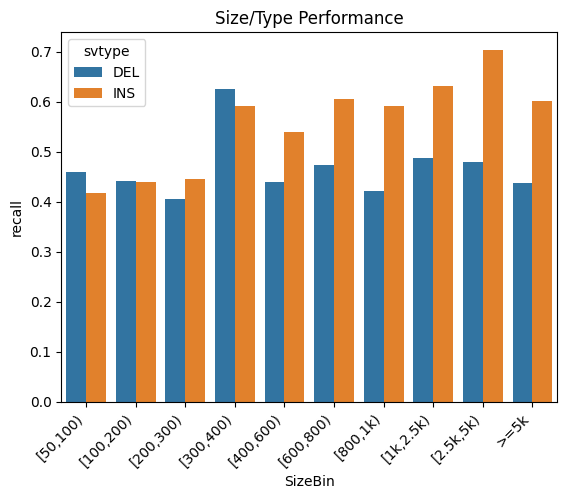

In [49]:
# Make the plot for recall
m_plot = size_type_barplot(strat1_table, "recall")

# VAF performance

Now, let's compare how well the predicted vaf matches the expected vaf. To do this, we'll use the 'vaf-delta'. This difference between predicted and expected vaf is expected to center around 0 (i.e. no-difference). Furthermore, we can check the correlation (PearsonR) and mean-square error MSE of the predicted vaf.

However, this can only be done on SVs that are matched between the baseline and comparison VCFs. Therefore, we'll first subset out dataframe to TP SVs.

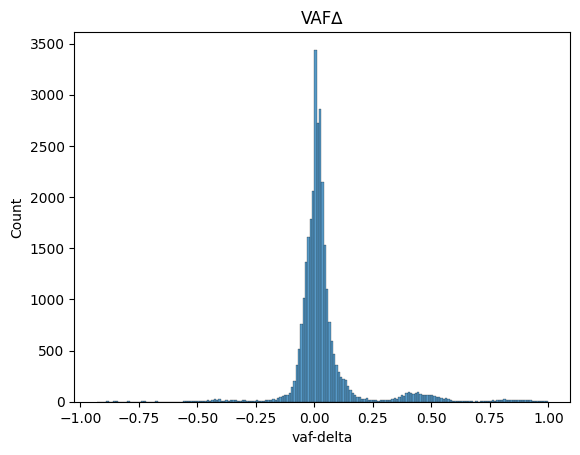

In [52]:
subset = data[data['state'] == 'tp']
                            
# Plot the vaf-delta
p = sb.histplot(data=subset, x='vaf-delta', binwidth=0.01)
_ = p.set(title="VAF∆")

In [53]:
vaf_result = vaf_performance(subset['predicted_vaf'], subset['expected_vaf'])
vaf_result

,0
count,30271.000000
mean,0.038735
std,0.153333
min,-0.929268
25%,-0.016760
50%,0.013375
75%,0.044244
max,0.997500
PearsonR,0.883485
Pval,0.000000


# Understanding Stratifications 

The above examples are a good start and seeing the overall pattern of the caller's performance. 
However, there are many more possible stratifications to explore. Let's next look at how well our caller performs on the 'germline' variants. We expect that they should be easier to find since they should have better higher read coverage.

One tricky aspect of getting the 'germline' set of variant states (e.g. tp/fp/tn) is that we'll need to rely on both the baseline's expected VAF and the comparison's predicted VAF. However, as we'll see later, these VAFs don't always match up.

precision: 0.875996, recall 0.885020, f1 0.880485


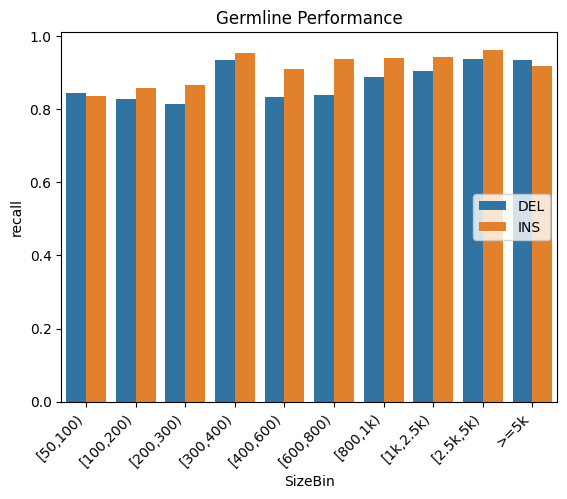

In [74]:
# Subset the data to anything with predicted/expected vaf bin of Medium or High
germline = data[data[['predicted_vaf_bin', 'expected_vaf_bin']].isin(['Medium', 'High']).any(axis=1)]
print("precision: %f, recall %f, f1 %f" % truvari.performance_metrics(**germline['state'].value_counts()))
germline_table = size_type_metrics(germline)
p = size_type_barplot(germline_table, title="Germline Performance")

# Let's move the svtype legend on our plot
_ = plt.legend(loc='center right')

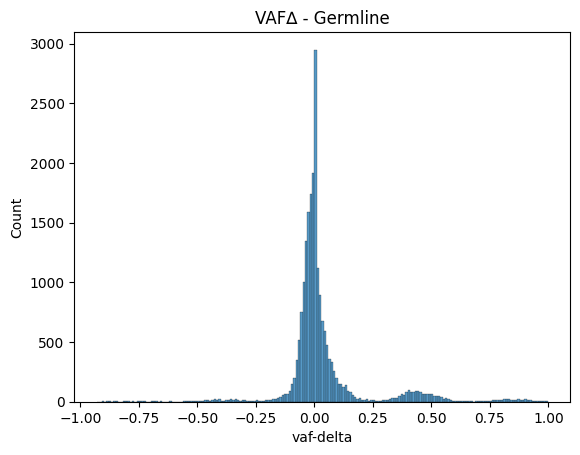

,0
count,21228.000000
mean,0.038070
std,0.181556
min,-0.929268
25%,-0.030048
50%,0.000000
75%,0.036521
max,0.997500
PearsonR,0.744473
Pval,0.000000


In [71]:
# Remember that we can only calculate vaf performance on matched variants
tp_germline = germline[germline['state'] == 'tp']

p = sb.histplot(data=tp_germline, x='vaf-delta', binwidth=0.01)
_ = p.set(title="VAF∆ - Germline")
plt.show()

germline_vaf_result = vaf_performance(tp_germline['predicted_vaf'], tp_germline['expected_vaf'])
germline_vaf_result

Generally, these germline results should be better than the overall results because, again, germline variants are easier to find than mosaic variants.

Now, let's look at mosaic variants.

precision: 0.859099, recall 0.392407, f1 0.538738


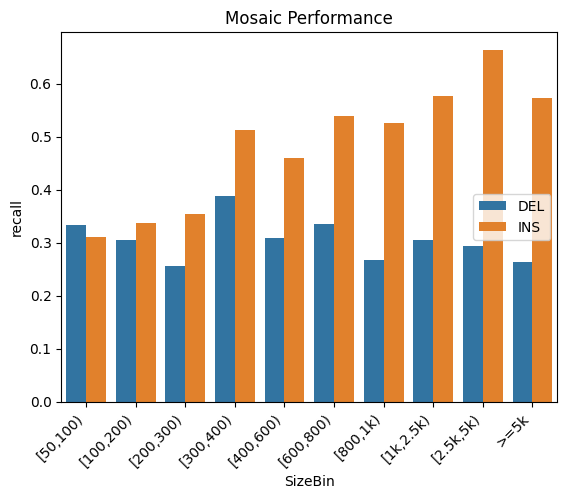

In [94]:
# Subset the data to anything with predicted/expected vaf bin of Medium or High
mosaic = data[data[['predicted_vaf_bin', 'expected_vaf_bin']].isin(['Ultra-Low', 'Low']).any(axis=1)]
print("precision: %f, recall %f, f1 %f" % truvari.performance_metrics(**mosaic['state'].value_counts()))
mosaic_table = size_type_metrics(mosaic)
p = size_type_barplot(mosaic_table, title="Mosaic Performance")

# Let's move the svtype legend on our plot
_ = plt.legend(loc='center right')

To do these germline and mosiac stratifications, we checked if either the predicted or expected vaf was above/below 0.3. However, this isn't a perfect separation because a single variant may be predicted germline but expected mosaic.

In [83]:
data.groupby(['predicted_vaf_bin', 'expected_vaf_bin'], observed=True).size().unstack()

expected_vaf_bin,Ultra-Low,Low,Medium,High
predicted_vaf_bin,,,,
Low,4515,17381,425,85
Medium,8387,3222,24555,379
High,5891,2392,3841,11676


If we wanted a more systematic separation, we'd either require that the predicted/expected vaf are in the same vaf bin. Alternatively, we would only stratify on either the predicted vaf or the expected vaf. 

If we choose the former option, we'd be biasing towards SVs which are more likely correct. In this example data, there are no 'Ultra-Low' predicted vaf SVs. Therefore, the subset mosaic variants in the same vaf bin will only be those of Low (≥0.5, <0.30) VAF. Any TPs where the baseline variant is expected to be Low VAF but it matched to a misannotated 'germline' comparison variant wouldn't be in this set.

It's easier to stratify by just the predicted or expected vaf bin. The consequence of this will be that you lose the ability to measure the recall or precision, respectively. For example, if we only grab variants with an expected vaf bin of Ultra-Low or Low, we will see no FP variants. This is because FP variants have no match in the baseline and therefore now expected vaf annotation. And, if we stratify by only the predicted vaf, we'll have no FNs and therefore no ability to measure the recall.

# Neighbors and TR annotations

Most SVs are within Tandem Repeats, therefore this is an important stratifications. Another important stratification is number of neighbors. Generally, variants within TRs are going to have neighbors, so these two stratifications are very related. 

Furthermore, SVs with Neighbors are typically more difficult to resolve. So before we explore the more complex regions, let's subset to the 'simple' variants and easier tests. 

Let's see how many variants have no neighbors and then see how well the tool performs on them.

In [90]:
isolated_subset = data[(data['NumNeighbors'] == 0)]

iso_counts = isolated_subset.groupby(['expected_vaf_bin'], observed=False)['state'].value_counts().unstack()
iso_counts['recall'] = iso_counts['tpbase'] / iso_counts[['tpbase', 'fn']].sum(axis=1)
iso_counts

state,tpbase,fn,tp,fp,recall
expected_vaf_bin,,,,,
Ultra-Low,103,6451,104,0,0.015716
Low,3053,825,3053,0,0.787261
Medium,3026,85,3033,0,0.972678
High,2144,36,2148,0,0.983486


In [91]:
neighbor_subset = data[(data['NumNeighbors'] != 0)]

neigh_counts = neighbor_subset.groupby(['expected_vaf_bin'], observed=False)['state'].value_counts().unstack()
neigh_counts['recall'] = neigh_counts['tpbase'] / neigh_counts[['tpbase', 'fn']].sum(axis=1)
neigh_counts

state,tpbase,fn,tp,fp,recall
expected_vaf_bin,,,,,
Ultra-Low,17225,32846,1361,0,0.344012
Low,10885,8661,6004,0,0.556891
Medium,12909,4325,9853,0,0.749043
High,3133,702,4715,0,0.816949


The isolated variants without neighbors have a better recall when their expected VAF is not Ultra-Low.

The Ultra-Low VAF variants having worse recall when they're isolated is due to how the benchmarking was performed. Remember that we used `truvari bench --pick multi`. When there are neighboring variants, they're likely highly similar to one another. Therefore, if a caller finds one variant in the neighborhood, there's a decent chance that variant is similar enough to be considered matching to all the variants in the neighborhood. 